Long Short-Term Memory - Speaker Dependent

In [1]:
# import library
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random as rn

In [2]:
# clone dataset from github
!git clone https://github.com/miftanurfarid/speech_emotion_recognition/

Cloning into 'speech_emotion_recognition'...
remote: Enumerating objects: 6970, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 6970 (delta 66), reused 101 (delta 59), pack-reused 6861
Receiving objects: 100% (6970/6970), 745.22 MiB | 25.59 MiB/s, done.
Resolving deltas: 100% (386/386), done.
Checking out files: 100% (5306/5306), done.


In [3]:
cd speech_emotion_recognition

/content/speech_emotion_recognition


In [4]:
np.random.seed(123)
rn.seed(123)
tf.random.set_seed(123)

In [5]:
# load feature data
data_path = 'data/song/' # choose song or speech
X = np.load(data_path + 'x.npy')
y = np.load(data_path + 'y.npy')

# reshape x untuk lstm
X = X.reshape((X.shape[0], 1, X.shape[1]))

# if labels are not in integer, convert it, otherwise comment it
y = y.astype(int)

In [6]:
# split into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10,
                                             restore_best_weights=True)
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

In [7]:
# function to define model
def model_lstm():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(axis=-1,
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    # compile model: set loss, optimizer, metric
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [8]:
# create the model
model = model_lstm()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1, 386)           1544      
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 1, 256)            658432    
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            525312    
                                                                 
 lstm_2 (LSTM)               (None, 1, 256)            525312    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [9]:
# plot model
tf.keras.utils.plot_model(model,'lstm_model_sd.pdf',show_shapes=True)

In [10]:
# train the model
hist = model.fit(x_train, 
                 y_train, 
                 epochs=100, 
                 shuffle=True, # mengacak data
                #  callbacks=earlystop, # akan berhenti saat konvergen meskipun belum sampai maksimal iterasi
                 validation_split=0.1, # 1% utk validasi
                 batch_size=16) # setiap 1 kali training ada 16 sampel

Epoch 1/100
52/52 [==============================] - 8s 50ms/step - loss: 1.4502 - accuracy: 0.4225 - val_loss: 2.1228 - val_accuracy: 0.3626
Epoch 2/100
52/52 [==============================] - 1s 27ms/step - loss: 0.7445 - accuracy: 0.7424 - val_loss: 1.4146 - val_accuracy: 0.5055
Epoch 3/100
52/52 [==============================] - 1s 25ms/step - loss: 0.4384 - accuracy: 0.8303 - val_loss: 0.9443 - val_accuracy: 0.6593
Epoch 4/100
52/52 [==============================] - 1s 24ms/step - loss: 0.4278 - accuracy: 0.8303 - val_loss: 0.6521 - val_accuracy: 0.7363
Epoch 5/100
52/52 [==============================] - 1s 25ms/step - loss: 0.3581 - accuracy: 0.8669 - val_loss: 0.4997 - val_accuracy: 0.8132
Epoch 6/100
52/52 [==============================] - 1s 24ms/step - loss: 0.2761 - accuracy: 0.8913 - val_loss: 0.3766 - val_accuracy: 0.8791
Epoch 7/100
52/52 [==============================] - 1s 24ms/step - loss: 0.2437 - accuracy: 0.9158 - val_loss: 0.3082 - val_accuracy: 0.8681
Epoch 

In [11]:
evaluate = model.evaluate(x_test, y_test, batch_size=16)

print("Loss={:.6f}, Accuracy={:.6f}".format(evaluate[0],evaluate[1]))

7/7 [==============================] - 0s 5ms/step - loss: 0.4151 - accuracy: 0.9118
Loss=0.415090, Accuracy=0.911765


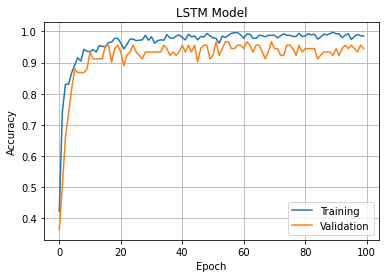

In [12]:
# plot accuracy
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.grid()
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model')
plt.savefig('lstm_accuracy_sd.svg')

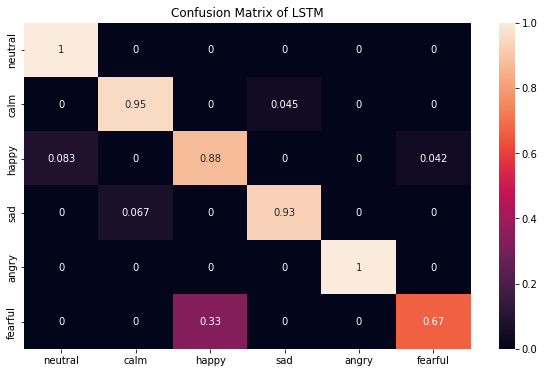

In [13]:
# make prediction for confusion_matrix
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
predict = model.predict(x_test, batch_size=16)
emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']

# predicted emotions from the test set
y_pred = np.argmax(predict, 1)
predicted_emo = []
for i in range(0,y_test.shape[0]):
    emo = emotions[y_pred[i]]
    predicted_emo.append(emo)

# get actual emotion
actual_emo = []
y_true = y_test
for i in range(0,y_test.shape[0]):
    emo = emotions[y_true[i]]
    actual_emo.append(emo)

# generate the confusion matrix
cm = confusion_matrix(actual_emo, predicted_emo)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
cm_df = pd.DataFrame(cm, index, columns)
plt.figure(figsize=(10, 6))
plt.title('Confusion Matrix of LSTM')
sns.heatmap(cm_df, annot=True)
plt.savefig('lstm_cm_sd.svg')

In [14]:
# print unweighted average recall
print("UAR: ", cm.trace()/cm.shape[0])

UAR:  0.9049242424242424
